## Libraries

In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
lst_files = os.listdir("../input")
lst_files = [os.path.join('../input', x) for x in lst_files]
lst_files

['../input/sales_train.csv.gz',
 '../input/test.csv.gz',
 '../input/items.csv',
 '../input/sample_submission.csv.gz',
 '../input/shops.csv',
 '../input/item_categories.csv']

### Loading data

In [3]:
# Reading in all datasets
train = pd.read_csv(lst_files[0])
test = pd.read_csv(lst_files[1])
items = pd.read_csv(lst_files[2])
sample_sub = pd.read_csv(lst_files[3])
shops = pd.read_csv(lst_files[4])
cat = pd.read_csv(lst_files[5])

In [4]:
# Merge all datasets into full_train
full_train = train.merge(items, on='item_id')
full_train = full_train.merge(cat, on='item_category_id')
full_train = full_train.merge(shops, on='shop_id')

In [5]:
full_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.0,2.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""


## EDA

In [69]:
full_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [6]:
# Remove negative pricing
full_train1 = full_train[~(full_train['item_price'] < 0)]

In [7]:
# Remove negative no. of product sold in a day
full_train1 = full_train1[~(full_train1['item_cnt_day'] < 0)]

**Trying to figure out if negative no. of products sold is normal and should be kept.   
Could not really tell after plotting out the `item_cnt_day` values for negative and full.  
Will remove them until further evidence surfaces**

In [73]:
full_train[full_train['item_cnt_day'] < 0].groupby('date_block_num').count()

,date,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
date_block_num,,,,,,,,,
0,352,352,352,352,352,352,352,352,352
1,287,287,287,287,287,287,287,287,287
2,294,294,294,294,294,294,294,294,294
3,244,244,244,244,244,244,244,244,244
4,177,177,177,177,177,177,177,177,177
5,201,201,201,201,201,201,201,201,201
6,198,198,198,198,198,198,198,198,198
7,277,277,277,277,277,277,277,277,277
8,219,219,219,219,219,219,219,219,219


In [54]:
x_axis = full_train[full_train['item_cnt_day'] < 0].groupby('date_block_num').count().index

In [55]:
y_axis = full_train[full_train['item_cnt_day'] < 0].groupby('date_block_num').count()['item_cnt_day'].values

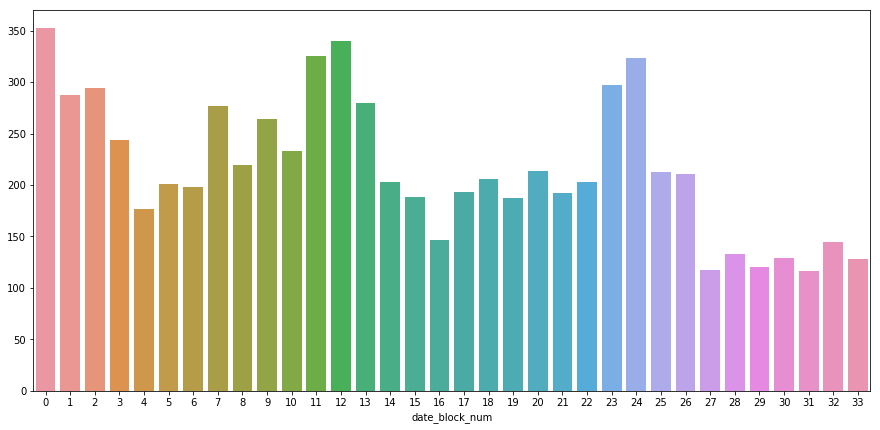

In [56]:
sns.barplot(x_axis, y_axis)
plt.rcParams['figure.figsize'] = [15, 7]
plt.show()

In [23]:
full_train.groupby('date_block_num').count()

,date,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
date_block_num,,,,,,,,,
0,115690,115690,115690,115690,115690,115690,115690,115690,115690
1,108613,108613,108613,108613,108613,108613,108613,108613,108613
2,121347,121347,121347,121347,121347,121347,121347,121347,121347
3,94109,94109,94109,94109,94109,94109,94109,94109,94109
4,91758,91758,91758,91758,91758,91758,91758,91758,91758
5,100403,100403,100403,100403,100403,100403,100403,100403,100403
6,100548,100548,100548,100548,100548,100548,100548,100548,100548
7,104772,104772,104772,104772,104772,104772,104772,104772,104772
8,96137,96137,96137,96137,96137,96137,96137,96137,96137


In [57]:
x_axis1 = full_train.groupby('date_block_num').count().index

In [58]:
y_axis1 = full_train.groupby('date_block_num').count()['item_cnt_day'].values

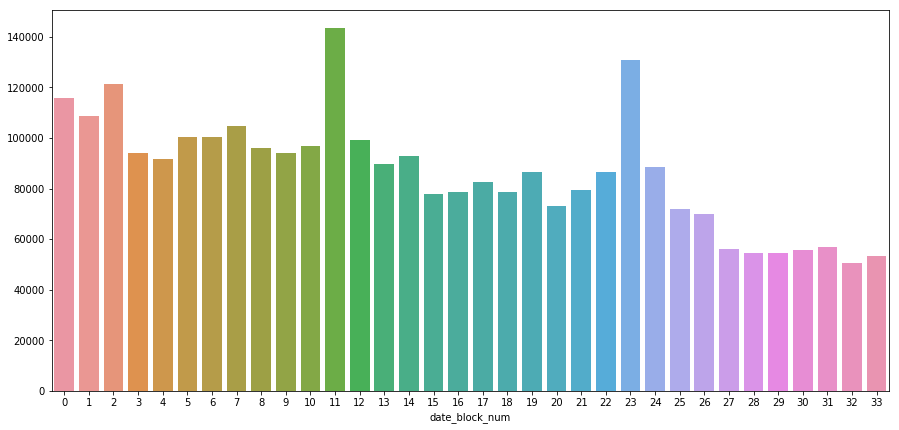

In [59]:
sns.barplot(x_axis1, y_axis1)
plt.rcParams['figure.figsize'] = [15, 7]
plt.show()

**Sales in 11 (December 2013) and 23 (December 2014) is the highest
What happened in 2015 that led to huge fall in sales?**

** Checking for correlation between independent variables**

In [62]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


In [87]:
columns = ['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_cnt_day']

In [99]:
correlation_matrix = pd.DataFrame(index=columns,
                                  columns=columns)

In [100]:
correlation_matrix

,date_block_num,shop_id,item_id,item_category_id,item_cnt_day
date_block_num,NaN,NaN,NaN,NaN,NaN
shop_id,NaN,NaN,NaN,NaN,NaN
item_id,NaN,NaN,NaN,NaN,NaN
item_category_id,NaN,NaN,NaN,NaN,NaN
item_cnt_day,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i in correlation_matrix.index:
    for j in correlation_matrix:
        x = full_train[j]
        y = full_train[i]
        
        if x.name == y.name:
            correlation_matrix[i][j] = 1.0
        else: 
#             print(x.name, y.name)
            v = cramers_v(x,y)
            correlation_matrix[i][j] = v

In [107]:
correlation_matrix

,date_block_num,shop_id,item_id,item_category_id,item_cnt_day
date_block_num,1,0.0826512,0.301734,0.0756157,0.0132518
shop_id,0.0826512,1,0.174125,0.150569,0.0191566
item_id,0.301734,0.174125,1,0.996293,0.0383888
item_category_id,0.0756157,0.150569,0.996293,1,0.053945
item_cnt_day,0.0132518,0.0191566,0.0383888,0.053945,1


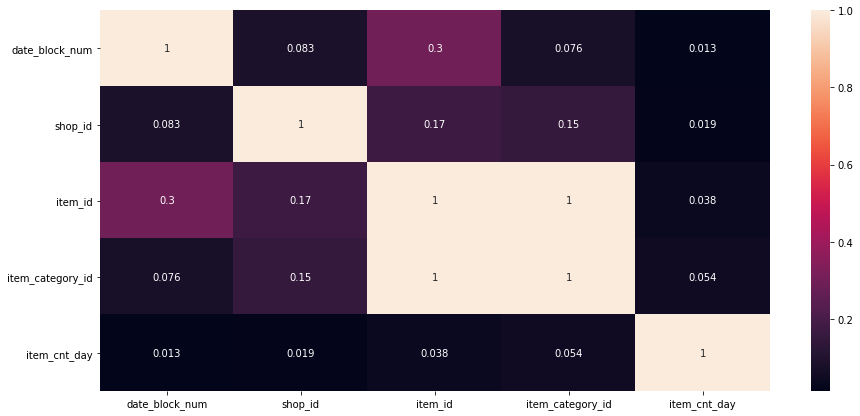

In [111]:
correlation_matrix.fillna(value=np.nan, inplace=True)
plt.figure(figsize=(15,7))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

** Check for outliers **
* TODO decide if we should remove outliers

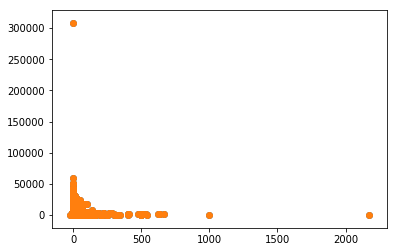

In [12]:
plt.scatter(full_train['item_cnt_day'], full_train['item_price'])
plt.show()

** Outlier on item_cnt_day >>>> 1000 and item_price >>>>100,000  
Check these records and see if we should remove them **


In [13]:
full_train[full_train['item_cnt_day'] > 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
2694327,28.10.2015,33,12,11373,0.908714,2169.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС


In [14]:
full_train[full_train['item_id'] == 11373].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,464.000000,464.0,464.0,464.000000,464.000000,464.0
mean,19.948276,12.0,11373.0,367.548909,14.144397,9.0
std,8.817658,0.0,0.0,296.953061,104.604937,0.0
min,0.000000,12.0,11373.0,0.908714,1.000000,9.0
25%,13.000000,12.0,11373.0,184.616848,2.000000,9.0
50%,21.000000,12.0,11373.0,281.625000,4.000000,9.0
75%,28.000000,12.0,11373.0,443.083333,8.000000,9.0
max,33.000000,12.0,11373.0,2137.000000,2169.000000,9.0


In [13]:
full_train[full_train['item_id'] == 11373].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
2693870,08.01.2013,0,12,11373,1000.0,1.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2693871,31.01.2013,0,12,11373,97.8,5.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2693872,01.02.2013,1,12,11373,229.0,1.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2693873,04.02.2013,1,12,11373,130.0,1.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2693874,29.03.2013,2,12,11373,139.5,2.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС


Item is a delivery service which only shop_id 12 has. Could remove this outlier to ensure better scaling.

** Check if all item_id to item_price is unique **

In [41]:
full_train[['shop_id','item_id', 'item_price']].groupby('item_id').get_group(3)

,shop_id,item_id,item_price
915726,54,3,100.0
915727,54,3,58.0


In [44]:
full_train[['shop_id', 'item_id','item_price']].groupby('item_id').get_group(22141)

,shop_id,item_id,item_price
29177,59,22141,399.0
29178,59,22141,399.0
307923,25,22141,399.0
307924,25,22141,399.0
307925,25,22141,399.0
307926,25,22141,399.0
307927,25,22141,399.0
307928,25,22141,399.0
307929,25,22141,399.0
440974,6,22141,399.0


** Nope, an item at same shop could be sold at different price, item is not unique to a shop**

** Check for duplicated shop names with different id **

In [7]:
shops.sort_values(by='shop_name')

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


** Create new feature: city**

## Preprocessing

In [46]:
train = full_train1.groupby(['date_block_num',
              'shop_id',
              'item_id']).agg({'item_cnt_day': ['sum']})

In [47]:
train.columns = ['item_cnt_month']

In [48]:
train = train.reset_index()

In [44]:
#TODO Wrong! This does a sum for all months for a shop_id and item_id.

In [49]:
train.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [78]:
train.item_cnt_month.value_counts()

1.0       1060054
2.0        266172
3.0        103481
4.0         53491
5.0         32037
6.0         20804
7.0         14087
8.0         10464
9.0          7546
10.0         6045
11.0         4486
12.0         3711
13.0         3066
14.0         2457
15.0         2075
16.0         1751
17.0         1576
18.0         1305
19.0         1106
20.0         1037
21.0          827
22.0          728
23.0          665
24.0          545
25.0          518
26.0          480
27.0          425
28.0          412
29.0          367
30.0          335
           ...   
142.0           1
941.0           1
430.0           1
431.0           1
904.0           1
903.0           1
899.0           1
1066.0          1
404.0           1
1074.0          1
374.0           1
365.0           1
369.0           1
370.0           1
272.0           1
1242.0          1
371.0           1
373.0           1
1209.0          1
375.0           1
401.0           1
432.0           1
378.0           1
380.0           1
1127.0    

In [12]:
# Labels
y = train.item_cnt_month.values

In [13]:
train = train.drop(['date_block_num', 'item_cnt_month'], axis=1)
x = train.values

In [14]:
# Create training and validation sets
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Models

### LightGBM

In [37]:
# Create LightGBM data containers
train_data = lgb.Dataset(x, label=y,)

In [38]:
test_data = lgb.Dataset(x_test, label=y_test)

In [42]:
# Parameters
parameters = {
    'objective': 'regression',
    'metric': 'rmse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.08,
    'verbose':0,
    'random_state':42
}

In [43]:
# Model 
model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       )

[1]	valid_0's rmse: 8.89727
[2]	valid_0's rmse: 8.89469
[3]	valid_0's rmse: 8.86892
[4]	valid_0's rmse: 8.86678
[5]	valid_0's rmse: 8.84525
[6]	valid_0's rmse: 8.8435
[7]	valid_0's rmse: 8.82527
[8]	valid_0's rmse: 8.82375
[9]	valid_0's rmse: 8.80865
[10]	valid_0's rmse: 8.8074
[11]	valid_0's rmse: 8.79481
[12]	valid_0's rmse: 8.79375
[13]	valid_0's rmse: 8.78318
[14]	valid_0's rmse: 8.78226
[15]	valid_0's rmse: 8.77325
[16]	valid_0's rmse: 8.77247
[17]	valid_0's rmse: 8.76529
[18]	valid_0's rmse: 8.76463
[19]	valid_0's rmse: 8.75831
[20]	valid_0's rmse: 8.75774
[21]	valid_0's rmse: 8.75173
[22]	valid_0's rmse: 8.75118
[23]	valid_0's rmse: 8.74644
[24]	valid_0's rmse: 8.74597
[25]	valid_0's rmse: 8.74167
[26]	valid_0's rmse: 8.74126
[27]	valid_0's rmse: 8.73813
[28]	valid_0's rmse: 8.73778
[29]	valid_0's rmse: 8.73507
[30]	valid_0's rmse: 8.73477
[31]	valid_0's rmse: 8.73245
[32]	valid_0's rmse: 8.73218
[33]	valid_0's rmse: 8.73043
[34]	valid_0's rmse: 8.7302
[35]	valid_0's rmse: 8.728

[282]	valid_0's rmse: 8.71746
[283]	valid_0's rmse: 8.71776
[284]	valid_0's rmse: 8.71775
[285]	valid_0's rmse: 8.71805
[286]	valid_0's rmse: 8.71804
[287]	valid_0's rmse: 8.71833
[288]	valid_0's rmse: 8.71832
[289]	valid_0's rmse: 8.7186
[290]	valid_0's rmse: 8.71859
[291]	valid_0's rmse: 8.71887
[292]	valid_0's rmse: 8.71887
[293]	valid_0's rmse: 8.71913
[294]	valid_0's rmse: 8.71912
[295]	valid_0's rmse: 8.71938
[296]	valid_0's rmse: 8.71938
[297]	valid_0's rmse: 8.7196
[298]	valid_0's rmse: 8.71959
[299]	valid_0's rmse: 8.71983
[300]	valid_0's rmse: 8.71983
[301]	valid_0's rmse: 8.71966
[302]	valid_0's rmse: 8.71967
[303]	valid_0's rmse: 8.71952
[304]	valid_0's rmse: 8.71953
[305]	valid_0's rmse: 8.71941
[306]	valid_0's rmse: 8.71943
[307]	valid_0's rmse: 8.71932
[308]	valid_0's rmse: 8.71934
[309]	valid_0's rmse: 8.71925
[310]	valid_0's rmse: 8.71927
[311]	valid_0's rmse: 8.71919
[312]	valid_0's rmse: 8.71922
[313]	valid_0's rmse: 8.71908
[314]	valid_0's rmse: 8.71911
[315]	valid_

[561]	valid_0's rmse: 8.71778
[562]	valid_0's rmse: 8.71776
[563]	valid_0's rmse: 8.71785
[564]	valid_0's rmse: 8.71784
[565]	valid_0's rmse: 8.71792
[566]	valid_0's rmse: 8.71791
[567]	valid_0's rmse: 8.71799
[568]	valid_0's rmse: 8.71799
[569]	valid_0's rmse: 8.71806
[570]	valid_0's rmse: 8.71806
[571]	valid_0's rmse: 8.71813
[572]	valid_0's rmse: 8.71812
[573]	valid_0's rmse: 8.71819
[574]	valid_0's rmse: 8.71818
[575]	valid_0's rmse: 8.71824
[576]	valid_0's rmse: 8.71824
[577]	valid_0's rmse: 8.71829
[578]	valid_0's rmse: 8.71829
[579]	valid_0's rmse: 8.71834
[580]	valid_0's rmse: 8.71834
[581]	valid_0's rmse: 8.71837
[582]	valid_0's rmse: 8.71837
[583]	valid_0's rmse: 8.71839
[584]	valid_0's rmse: 8.71839
[585]	valid_0's rmse: 8.71842
[586]	valid_0's rmse: 8.71843
[587]	valid_0's rmse: 8.71846
[588]	valid_0's rmse: 8.71846
[589]	valid_0's rmse: 8.71849
[590]	valid_0's rmse: 8.7185
[591]	valid_0's rmse: 8.71852
[592]	valid_0's rmse: 8.71853
[593]	valid_0's rmse: 8.71856
[594]	valid

[839]	valid_0's rmse: 8.71773
[840]	valid_0's rmse: 8.71774
[841]	valid_0's rmse: 8.71737
[842]	valid_0's rmse: 8.71737
[843]	valid_0's rmse: 8.71704
[844]	valid_0's rmse: 8.71704
[845]	valid_0's rmse: 8.71675
[846]	valid_0's rmse: 8.71676
[847]	valid_0's rmse: 8.7165
[848]	valid_0's rmse: 8.71651
[849]	valid_0's rmse: 8.71628
[850]	valid_0's rmse: 8.71628
[851]	valid_0's rmse: 8.71607
[852]	valid_0's rmse: 8.71607
[853]	valid_0's rmse: 8.71589
[854]	valid_0's rmse: 8.71589
[855]	valid_0's rmse: 8.71572
[856]	valid_0's rmse: 8.71573
[857]	valid_0's rmse: 8.71558
[858]	valid_0's rmse: 8.71559
[859]	valid_0's rmse: 8.71546
[860]	valid_0's rmse: 8.71546
[861]	valid_0's rmse: 8.71505
[862]	valid_0's rmse: 8.71504
[863]	valid_0's rmse: 8.71468
[864]	valid_0's rmse: 8.71467
[865]	valid_0's rmse: 8.71437
[866]	valid_0's rmse: 8.71437
[867]	valid_0's rmse: 8.71411
[868]	valid_0's rmse: 8.7141
[869]	valid_0's rmse: 8.71388
[870]	valid_0's rmse: 8.71387
[871]	valid_0's rmse: 8.71368
[872]	valid_

[1110]	valid_0's rmse: 8.7137
[1111]	valid_0's rmse: 8.71372
[1112]	valid_0's rmse: 8.71373
[1113]	valid_0's rmse: 8.71371
[1114]	valid_0's rmse: 8.71372
[1115]	valid_0's rmse: 8.71375
[1116]	valid_0's rmse: 8.71376
[1117]	valid_0's rmse: 8.71378
[1118]	valid_0's rmse: 8.71379
[1119]	valid_0's rmse: 8.71381
[1120]	valid_0's rmse: 8.71382
[1121]	valid_0's rmse: 8.71419
[1122]	valid_0's rmse: 8.71415
[1123]	valid_0's rmse: 8.71453
[1124]	valid_0's rmse: 8.7145
[1125]	valid_0's rmse: 8.71486
[1126]	valid_0's rmse: 8.71484
[1127]	valid_0's rmse: 8.71519
[1128]	valid_0's rmse: 8.71517
[1129]	valid_0's rmse: 8.71552
[1130]	valid_0's rmse: 8.7155
[1131]	valid_0's rmse: 8.71584
[1132]	valid_0's rmse: 8.71582
[1133]	valid_0's rmse: 8.71615
[1134]	valid_0's rmse: 8.71614
[1135]	valid_0's rmse: 8.71644
[1136]	valid_0's rmse: 8.71643
[1137]	valid_0's rmse: 8.71672
[1138]	valid_0's rmse: 8.71671
[1139]	valid_0's rmse: 8.71698
[1140]	valid_0's rmse: 8.71698
[1141]	valid_0's rmse: 8.71694
[1142]	vali

[1381]	valid_0's rmse: 8.71399
[1382]	valid_0's rmse: 8.71397
[1383]	valid_0's rmse: 8.71404
[1384]	valid_0's rmse: 8.71403
[1385]	valid_0's rmse: 8.71409
[1386]	valid_0's rmse: 8.71409
[1387]	valid_0's rmse: 8.71415
[1388]	valid_0's rmse: 8.71415
[1389]	valid_0's rmse: 8.71418
[1390]	valid_0's rmse: 8.71418
[1391]	valid_0's rmse: 8.7142
[1392]	valid_0's rmse: 8.7142
[1393]	valid_0's rmse: 8.71426
[1394]	valid_0's rmse: 8.71427
[1395]	valid_0's rmse: 8.71429
[1396]	valid_0's rmse: 8.7143
[1397]	valid_0's rmse: 8.71432
[1398]	valid_0's rmse: 8.71433
[1399]	valid_0's rmse: 8.71435
[1400]	valid_0's rmse: 8.71436
[1401]	valid_0's rmse: 8.71426
[1402]	valid_0's rmse: 8.71424
[1403]	valid_0's rmse: 8.71413
[1404]	valid_0's rmse: 8.71412
[1405]	valid_0's rmse: 8.71404
[1406]	valid_0's rmse: 8.71403
[1407]	valid_0's rmse: 8.71396
[1408]	valid_0's rmse: 8.71395
[1409]	valid_0's rmse: 8.71389
[1410]	valid_0's rmse: 8.71388
[1411]	valid_0's rmse: 8.71383
[1412]	valid_0's rmse: 8.71383
[1413]	vali

[1650]	valid_0's rmse: 8.7148
[1651]	valid_0's rmse: 8.71493
[1652]	valid_0's rmse: 8.71493
[1653]	valid_0's rmse: 8.71507
[1654]	valid_0's rmse: 8.71507
[1655]	valid_0's rmse: 8.71518
[1656]	valid_0's rmse: 8.71518
[1657]	valid_0's rmse: 8.71529
[1658]	valid_0's rmse: 8.71529
[1659]	valid_0's rmse: 8.7154
[1660]	valid_0's rmse: 8.71541
[1661]	valid_0's rmse: 8.71553
[1662]	valid_0's rmse: 8.71552
[1663]	valid_0's rmse: 8.71562
[1664]	valid_0's rmse: 8.71561
[1665]	valid_0's rmse: 8.71573
[1666]	valid_0's rmse: 8.71572
[1667]	valid_0's rmse: 8.71582
[1668]	valid_0's rmse: 8.71581
[1669]	valid_0's rmse: 8.7159
[1670]	valid_0's rmse: 8.7159
[1671]	valid_0's rmse: 8.71599
[1672]	valid_0's rmse: 8.71599
[1673]	valid_0's rmse: 8.71608
[1674]	valid_0's rmse: 8.71608
[1675]	valid_0's rmse: 8.71616
[1676]	valid_0's rmse: 8.71616
[1677]	valid_0's rmse: 8.71623
[1678]	valid_0's rmse: 8.71623
[1679]	valid_0's rmse: 8.7163
[1680]	valid_0's rmse: 8.7163
[1681]	valid_0's rmse: 8.71608
[1682]	valid_0

[1917]	valid_0's rmse: 8.71816
[1918]	valid_0's rmse: 8.71816
[1919]	valid_0's rmse: 8.71816
[1920]	valid_0's rmse: 8.71816
[1921]	valid_0's rmse: 8.7177
[1922]	valid_0's rmse: 8.7177
[1923]	valid_0's rmse: 8.71729
[1924]	valid_0's rmse: 8.71729
[1925]	valid_0's rmse: 8.71694
[1926]	valid_0's rmse: 8.71694
[1927]	valid_0's rmse: 8.71663
[1928]	valid_0's rmse: 8.71664
[1929]	valid_0's rmse: 8.71636
[1930]	valid_0's rmse: 8.71636
[1931]	valid_0's rmse: 8.71611
[1932]	valid_0's rmse: 8.71612
[1933]	valid_0's rmse: 8.71591
[1934]	valid_0's rmse: 8.71592
[1935]	valid_0's rmse: 8.71571
[1936]	valid_0's rmse: 8.71571
[1937]	valid_0's rmse: 8.71554
[1938]	valid_0's rmse: 8.71555
[1939]	valid_0's rmse: 8.71538
[1940]	valid_0's rmse: 8.71538
[1941]	valid_0's rmse: 8.71486
[1942]	valid_0's rmse: 8.71485
[1943]	valid_0's rmse: 8.71441
[1944]	valid_0's rmse: 8.71439
[1945]	valid_0's rmse: 8.71402
[1946]	valid_0's rmse: 8.71401
[1947]	valid_0's rmse: 8.71369
[1948]	valid_0's rmse: 8.71369
[1949]	val

[2183]	valid_0's rmse: 8.71717
[2184]	valid_0's rmse: 8.71716
[2185]	valid_0's rmse: 8.71717
[2186]	valid_0's rmse: 8.71716
[2187]	valid_0's rmse: 8.71717
[2188]	valid_0's rmse: 8.71717
[2189]	valid_0's rmse: 8.71718
[2190]	valid_0's rmse: 8.71718
[2191]	valid_0's rmse: 8.71719
[2192]	valid_0's rmse: 8.71719
[2193]	valid_0's rmse: 8.71722
[2194]	valid_0's rmse: 8.71722
[2195]	valid_0's rmse: 8.71723
[2196]	valid_0's rmse: 8.71723
[2197]	valid_0's rmse: 8.71725
[2198]	valid_0's rmse: 8.71725
[2199]	valid_0's rmse: 8.71726
[2200]	valid_0's rmse: 8.71726
[2201]	valid_0's rmse: 8.71735
[2202]	valid_0's rmse: 8.71731
[2203]	valid_0's rmse: 8.7174
[2204]	valid_0's rmse: 8.71736
[2205]	valid_0's rmse: 8.71745
[2206]	valid_0's rmse: 8.71742
[2207]	valid_0's rmse: 8.71751
[2208]	valid_0's rmse: 8.71749
[2209]	valid_0's rmse: 8.71758
[2210]	valid_0's rmse: 8.71756
[2211]	valid_0's rmse: 8.71765
[2212]	valid_0's rmse: 8.71764
[2213]	valid_0's rmse: 8.71772
[2214]	valid_0's rmse: 8.71771
[2215]	va

[2449]	valid_0's rmse: 8.71689
[2450]	valid_0's rmse: 8.71689
[2451]	valid_0's rmse: 8.71696
[2452]	valid_0's rmse: 8.71696
[2453]	valid_0's rmse: 8.71704
[2454]	valid_0's rmse: 8.71705
[2455]	valid_0's rmse: 8.71712
[2456]	valid_0's rmse: 8.71713
[2457]	valid_0's rmse: 8.7172
[2458]	valid_0's rmse: 8.71721
[2459]	valid_0's rmse: 8.71728
[2460]	valid_0's rmse: 8.71729
[2461]	valid_0's rmse: 8.71709
[2462]	valid_0's rmse: 8.7171
[2463]	valid_0's rmse: 8.71692
[2464]	valid_0's rmse: 8.71693
[2465]	valid_0's rmse: 8.71678
[2466]	valid_0's rmse: 8.71679
[2467]	valid_0's rmse: 8.71665
[2468]	valid_0's rmse: 8.71666
[2469]	valid_0's rmse: 8.71654
[2470]	valid_0's rmse: 8.71656
[2471]	valid_0's rmse: 8.71645
[2472]	valid_0's rmse: 8.71646
[2473]	valid_0's rmse: 8.71636
[2474]	valid_0's rmse: 8.71637
[2475]	valid_0's rmse: 8.71629
[2476]	valid_0's rmse: 8.7163
[2477]	valid_0's rmse: 8.71622
[2478]	valid_0's rmse: 8.71623
[2479]	valid_0's rmse: 8.71616
[2480]	valid_0's rmse: 8.71617
[2481]	vali

[2716]	valid_0's rmse: 8.71487
[2717]	valid_0's rmse: 8.7148
[2718]	valid_0's rmse: 8.7148
[2719]	valid_0's rmse: 8.71474
[2720]	valid_0's rmse: 8.71475
[2721]	valid_0's rmse: 8.71486
[2722]	valid_0's rmse: 8.71486
[2723]	valid_0's rmse: 8.71497
[2724]	valid_0's rmse: 8.71497
[2725]	valid_0's rmse: 8.71508
[2726]	valid_0's rmse: 8.71508
[2727]	valid_0's rmse: 8.71521
[2728]	valid_0's rmse: 8.71521
[2729]	valid_0's rmse: 8.71533
[2730]	valid_0's rmse: 8.71533
[2731]	valid_0's rmse: 8.71543
[2732]	valid_0's rmse: 8.71543
[2733]	valid_0's rmse: 8.71554
[2734]	valid_0's rmse: 8.71554
[2735]	valid_0's rmse: 8.71564
[2736]	valid_0's rmse: 8.71564
[2737]	valid_0's rmse: 8.71573
[2738]	valid_0's rmse: 8.71573
[2739]	valid_0's rmse: 8.71583
[2740]	valid_0's rmse: 8.71583
[2741]	valid_0's rmse: 8.71605
[2742]	valid_0's rmse: 8.71604
[2743]	valid_0's rmse: 8.71626
[2744]	valid_0's rmse: 8.71626
[2745]	valid_0's rmse: 8.71645
[2746]	valid_0's rmse: 8.71646
[2747]	valid_0's rmse: 8.7166
[2748]	vali

[2983]	valid_0's rmse: 8.71586
[2984]	valid_0's rmse: 8.71586
[2985]	valid_0's rmse: 8.71627
[2986]	valid_0's rmse: 8.71627
[2987]	valid_0's rmse: 8.71666
[2988]	valid_0's rmse: 8.71667
[2989]	valid_0's rmse: 8.71704
[2990]	valid_0's rmse: 8.71705
[2991]	valid_0's rmse: 8.71741
[2992]	valid_0's rmse: 8.71742
[2993]	valid_0's rmse: 8.71777
[2994]	valid_0's rmse: 8.71777
[2995]	valid_0's rmse: 8.7181
[2996]	valid_0's rmse: 8.71811
[2997]	valid_0's rmse: 8.71842
[2998]	valid_0's rmse: 8.71843
[2999]	valid_0's rmse: 8.71873
[3000]	valid_0's rmse: 8.71873
[3001]	valid_0's rmse: 8.71871
[3002]	valid_0's rmse: 8.71869
[3003]	valid_0's rmse: 8.71866
[3004]	valid_0's rmse: 8.71865
[3005]	valid_0's rmse: 8.71859
[3006]	valid_0's rmse: 8.71858
[3007]	valid_0's rmse: 8.71854
[3008]	valid_0's rmse: 8.71852
[3009]	valid_0's rmse: 8.71847
[3010]	valid_0's rmse: 8.71846
[3011]	valid_0's rmse: 8.71845
[3012]	valid_0's rmse: 8.71844
[3013]	valid_0's rmse: 8.71841
[3014]	valid_0's rmse: 8.7184
[3015]	val

[3248]	valid_0's rmse: 8.71572
[3249]	valid_0's rmse: 8.71556
[3250]	valid_0's rmse: 8.71555
[3251]	valid_0's rmse: 8.71542
[3252]	valid_0's rmse: 8.71541
[3253]	valid_0's rmse: 8.71529
[3254]	valid_0's rmse: 8.71529
[3255]	valid_0's rmse: 8.71517
[3256]	valid_0's rmse: 8.71517
[3257]	valid_0's rmse: 8.71507
[3258]	valid_0's rmse: 8.71507
[3259]	valid_0's rmse: 8.71498
[3260]	valid_0's rmse: 8.71498
[3261]	valid_0's rmse: 8.71471
[3262]	valid_0's rmse: 8.71471
[3263]	valid_0's rmse: 8.71447
[3264]	valid_0's rmse: 8.71447
[3265]	valid_0's rmse: 8.71427
[3266]	valid_0's rmse: 8.71426
[3267]	valid_0's rmse: 8.71408
[3268]	valid_0's rmse: 8.71408
[3269]	valid_0's rmse: 8.71393
[3270]	valid_0's rmse: 8.71392
[3271]	valid_0's rmse: 8.71378
[3272]	valid_0's rmse: 8.71379
[3273]	valid_0's rmse: 8.71366
[3274]	valid_0's rmse: 8.71366
[3275]	valid_0's rmse: 8.71355
[3276]	valid_0's rmse: 8.71355
[3277]	valid_0's rmse: 8.71345
[3278]	valid_0's rmse: 8.71345
[3279]	valid_0's rmse: 8.71337
[3280]	v

[3519]	valid_0's rmse: 8.71175
[3520]	valid_0's rmse: 8.71175
[3521]	valid_0's rmse: 8.71193
[3522]	valid_0's rmse: 8.71192
[3523]	valid_0's rmse: 8.71212
[3524]	valid_0's rmse: 8.71212
[3525]	valid_0's rmse: 8.71234
[3526]	valid_0's rmse: 8.71233
[3527]	valid_0's rmse: 8.71257
[3528]	valid_0's rmse: 8.71257
[3529]	valid_0's rmse: 8.71281
[3530]	valid_0's rmse: 8.71281
[3531]	valid_0's rmse: 8.71304
[3532]	valid_0's rmse: 8.71304
[3533]	valid_0's rmse: 8.71329
[3534]	valid_0's rmse: 8.71329
[3535]	valid_0's rmse: 8.71352
[3536]	valid_0's rmse: 8.71352
[3537]	valid_0's rmse: 8.71375
[3538]	valid_0's rmse: 8.71375
[3539]	valid_0's rmse: 8.71396
[3540]	valid_0's rmse: 8.71396
[3541]	valid_0's rmse: 8.71382
[3542]	valid_0's rmse: 8.71381
[3543]	valid_0's rmse: 8.71368
[3544]	valid_0's rmse: 8.71369
[3545]	valid_0's rmse: 8.71357
[3546]	valid_0's rmse: 8.71358
[3547]	valid_0's rmse: 8.71348
[3548]	valid_0's rmse: 8.71349
[3549]	valid_0's rmse: 8.7134
[3550]	valid_0's rmse: 8.71341
[3551]	va

[3785]	valid_0's rmse: 8.71424
[3786]	valid_0's rmse: 8.71424
[3787]	valid_0's rmse: 8.71423
[3788]	valid_0's rmse: 8.71423
[3789]	valid_0's rmse: 8.71425
[3790]	valid_0's rmse: 8.71426
[3791]	valid_0's rmse: 8.71426
[3792]	valid_0's rmse: 8.71426
[3793]	valid_0's rmse: 8.7143
[3794]	valid_0's rmse: 8.71431
[3795]	valid_0's rmse: 8.71434
[3796]	valid_0's rmse: 8.71435
[3797]	valid_0's rmse: 8.71434
[3798]	valid_0's rmse: 8.71436
[3799]	valid_0's rmse: 8.71439
[3800]	valid_0's rmse: 8.7144
[3801]	valid_0's rmse: 8.71437
[3802]	valid_0's rmse: 8.71435
[3803]	valid_0's rmse: 8.71432
[3804]	valid_0's rmse: 8.71431
[3805]	valid_0's rmse: 8.71428
[3806]	valid_0's rmse: 8.71426
[3807]	valid_0's rmse: 8.71425
[3808]	valid_0's rmse: 8.71424
[3809]	valid_0's rmse: 8.71422
[3810]	valid_0's rmse: 8.71421
[3811]	valid_0's rmse: 8.7142
[3812]	valid_0's rmse: 8.7142
[3813]	valid_0's rmse: 8.71416
[3814]	valid_0's rmse: 8.71416
[3815]	valid_0's rmse: 8.71415
[3816]	valid_0's rmse: 8.71415
[3817]	valid

[4055]	valid_0's rmse: 8.71446
[4056]	valid_0's rmse: 8.71447
[4057]	valid_0's rmse: 8.71443
[4058]	valid_0's rmse: 8.71443
[4059]	valid_0's rmse: 8.7144
[4060]	valid_0's rmse: 8.71441
[4061]	valid_0's rmse: 8.71462
[4062]	valid_0's rmse: 8.71461
[4063]	valid_0's rmse: 8.71484
[4064]	valid_0's rmse: 8.71484
[4065]	valid_0's rmse: 8.71504
[4066]	valid_0's rmse: 8.71504
[4067]	valid_0's rmse: 8.71523
[4068]	valid_0's rmse: 8.71524
[4069]	valid_0's rmse: 8.71544
[4070]	valid_0's rmse: 8.71544
[4071]	valid_0's rmse: 8.71562
[4072]	valid_0's rmse: 8.71562
[4073]	valid_0's rmse: 8.71579
[4074]	valid_0's rmse: 8.71579
[4075]	valid_0's rmse: 8.71595
[4076]	valid_0's rmse: 8.71596
[4077]	valid_0's rmse: 8.71611
[4078]	valid_0's rmse: 8.71611
[4079]	valid_0's rmse: 8.71627
[4080]	valid_0's rmse: 8.71627
[4081]	valid_0's rmse: 8.71601
[4082]	valid_0's rmse: 8.71599
[4083]	valid_0's rmse: 8.71575
[4084]	valid_0's rmse: 8.71574
[4085]	valid_0's rmse: 8.71553
[4086]	valid_0's rmse: 8.71552
[4087]	va

[4325]	valid_0's rmse: 8.71366
[4326]	valid_0's rmse: 8.71368
[4327]	valid_0's rmse: 8.71366
[4328]	valid_0's rmse: 8.71368
[4329]	valid_0's rmse: 8.71366
[4330]	valid_0's rmse: 8.71368
[4331]	valid_0's rmse: 8.71366
[4332]	valid_0's rmse: 8.71368
[4333]	valid_0's rmse: 8.71366
[4334]	valid_0's rmse: 8.71368
[4335]	valid_0's rmse: 8.71366
[4336]	valid_0's rmse: 8.71368
[4337]	valid_0's rmse: 8.71366
[4338]	valid_0's rmse: 8.71368
[4339]	valid_0's rmse: 8.71367
[4340]	valid_0's rmse: 8.71369
[4341]	valid_0's rmse: 8.71378
[4342]	valid_0's rmse: 8.71377
[4343]	valid_0's rmse: 8.71387
[4344]	valid_0's rmse: 8.71385
[4345]	valid_0's rmse: 8.71396
[4346]	valid_0's rmse: 8.71395
[4347]	valid_0's rmse: 8.71405
[4348]	valid_0's rmse: 8.71404
[4349]	valid_0's rmse: 8.71415
[4350]	valid_0's rmse: 8.71415
[4351]	valid_0's rmse: 8.71426
[4352]	valid_0's rmse: 8.71425
[4353]	valid_0's rmse: 8.71436
[4354]	valid_0's rmse: 8.71436
[4355]	valid_0's rmse: 8.71446
[4356]	valid_0's rmse: 8.71446
[4357]	v

[4594]	valid_0's rmse: 8.71637
[4595]	valid_0's rmse: 8.71654
[4596]	valid_0's rmse: 8.71654
[4597]	valid_0's rmse: 8.7167
[4598]	valid_0's rmse: 8.7167
[4599]	valid_0's rmse: 8.71687
[4600]	valid_0's rmse: 8.71687
[4601]	valid_0's rmse: 8.71651
[4602]	valid_0's rmse: 8.71651
[4603]	valid_0's rmse: 8.71619
[4604]	valid_0's rmse: 8.7162
[4605]	valid_0's rmse: 8.7159
[4606]	valid_0's rmse: 8.71591
[4607]	valid_0's rmse: 8.71566
[4608]	valid_0's rmse: 8.71567
[4609]	valid_0's rmse: 8.71544
[4610]	valid_0's rmse: 8.71545
[4611]	valid_0's rmse: 8.71526
[4612]	valid_0's rmse: 8.71527
[4613]	valid_0's rmse: 8.71509
[4614]	valid_0's rmse: 8.7151
[4615]	valid_0's rmse: 8.71495
[4616]	valid_0's rmse: 8.71496
[4617]	valid_0's rmse: 8.71482
[4618]	valid_0's rmse: 8.71483
[4619]	valid_0's rmse: 8.71471
[4620]	valid_0's rmse: 8.71472
[4621]	valid_0's rmse: 8.71489
[4622]	valid_0's rmse: 8.71489
[4623]	valid_0's rmse: 8.71505
[4624]	valid_0's rmse: 8.71504
[4625]	valid_0's rmse: 8.7152
[4626]	valid_0

[4865]	valid_0's rmse: 8.71776
[4866]	valid_0's rmse: 8.71775
[4867]	valid_0's rmse: 8.71798
[4868]	valid_0's rmse: 8.71798
[4869]	valid_0's rmse: 8.71819
[4870]	valid_0's rmse: 8.71819
[4871]	valid_0's rmse: 8.71839
[4872]	valid_0's rmse: 8.7184
[4873]	valid_0's rmse: 8.71859
[4874]	valid_0's rmse: 8.71859
[4875]	valid_0's rmse: 8.71877
[4876]	valid_0's rmse: 8.71878
[4877]	valid_0's rmse: 8.71894
[4878]	valid_0's rmse: 8.71895
[4879]	valid_0's rmse: 8.7191
[4880]	valid_0's rmse: 8.71911
[4881]	valid_0's rmse: 8.71824
[4882]	valid_0's rmse: 8.71822
[4883]	valid_0's rmse: 8.71747
[4884]	valid_0's rmse: 8.71746
[4885]	valid_0's rmse: 8.71682
[4886]	valid_0's rmse: 8.71682
[4887]	valid_0's rmse: 8.71625
[4888]	valid_0's rmse: 8.71626
[4889]	valid_0's rmse: 8.71577
[4890]	valid_0's rmse: 8.71578
[4891]	valid_0's rmse: 8.71535
[4892]	valid_0's rmse: 8.71536
[4893]	valid_0's rmse: 8.71499
[4894]	valid_0's rmse: 8.715
[4895]	valid_0's rmse: 8.71468
[4896]	valid_0's rmse: 8.71469
[4897]	valid

### Linear Regression
- one-hot encoding with categorical id

In [25]:
x = full_train[['shop_id','item_id']]

In [30]:
x.reset_index(inplace=True)

In [32]:
x = x.rename(columns={'index':'ID'})

In [33]:
y = full_train['item_cnt_day']

In [34]:
x = pd.get_dummies(data=x, drop_first=True)

In [35]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
lr.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [37]:
test = pd.get_dummies(data=test, drop_first=True)

In [38]:
score = lr.predict(test)

In [39]:
score

array([ 1.21754413,  1.21952824,  1.2189183 , ...,  1.25723734,
        1.28451701,  1.15355923])